In [1]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

#import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ib_async import *
util.startLoop()

### Data Prep for Inferencing

In [3]:
ib = IB()
ib.connect(port=7496, clientId=0)

<IB connected to 127.0.0.1:7496 clientId=0>

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; cashfarm; usopt; usfarm; ushmds; secdefil.


In [4]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS')]

In [5]:
contract_vix = Contract(symbol= 'VIX', secType = 'IND',exchange = 'CBOE', currency='USD')
ib.qualifyContracts(contract_vix)

[Contract(secType='IND', conId=13455763, symbol='VIX', exchange='CBOE', currency='USD', localSymbol='VIX')]

In [6]:
contract_nas = Contract(symbol= 'TQQQ', secType = 'STK',exchange = 'SMART', currency='USD')
ib.qualifyContracts(contract_nas)

[Contract(secType='STK', conId=72539702, symbol='TQQQ', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TQQQ', tradingClass='NMS')]

In [7]:
class Data_Request :

    """
    Returns PD data containning equity price with specific time control

    Returns:
        pd: information regarding the contract of interst.
    """
    
    def __init__(self, list_days, contract, barsize, duration, *,specific_time= None, specific_pick_time= None):

        self.list_days = list_days
        self.contract = contract
        #self.init_date = init_date
        self.barsize = barsize
        self.duration = duration
        self.specific_time = specific_time # cut off time . Time object: time(14, 30, 0)
        self.specific_pick_time= specific_pick_time

    def D_request(self):

        his_df =pd.DataFrame()
        
        for i in range(len(self.list_days)):
            init_date=self.list_days[i]
            bars = ib.reqHistoricalData(self.contract, init_date, barSizeSetting=self.barsize, durationStr=self.duration, whatToShow="TRADES", useRTH=True)
            add_his_df = pd.DataFrame(bars)
            add_his_df['date'] = pd.to_datetime(add_his_df['date'])
            print(f'retriveing data for {init_date}')

            if self.specific_time is not None:
                cut_off = datetime.combine(self.list_days[i],self.specific_time)  # need logic if specific_time is defined
                pd_cut_off = pd.to_datetime(cut_off).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] > pd_cut_off]
            
            if self.specific_pick_time is not None:
                pick_time = datetime.combine(self.list_days[i],self.specific_pick_time)  # need logic if specific_time is defined
                pd_pick_time = pd.to_datetime(pick_time).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] == pd_pick_time]

            
            his_df = pd.concat([his_df, add_his_df], ignore_index=True)
            his_df['Date_Only'] = his_df['date'].dt.date
            print(len(his_df))

        
        return his_df


In [8]:
# picking out Friday and before specific-time data

#specific_time = time(14, 30, 0)
def data_filter_v46(df_initial, list_days, specific_time_before = None, specific_time_after= None, on_time= None):
    his_df = pd.DataFrame()

    df_trimmed = df_initial[df_initial['date'].dt.date.isin(list_days)]

    if specific_time_before is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time < specific_time_before)]
        
            
    if specific_time_after is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time >= specific_time_after)]

    if on_time is not None:
        his_df = df_trimmed[(df_trimmed['date'].dt.time == on_time)]

    if (specific_time_before is None and specific_time_after is None) and on_time is None:

        his_df = df_trimmed
        
    return his_df

In [9]:
# picking out Friday and before specific-time data

#specific_time = time(14, 30, 0)
def data_filter(df_initial, list_days, specific_time_before = None, specific_time_after= None, on_time= None):
    his_df = pd.DataFrame()
    for i in range(len(list_days)):
        init_date=list_days[i]
        if specific_time_before is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time < specific_time_before)]
           
            
        if specific_time_after is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time >= specific_time_after)]

        if on_time is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time == on_time)]

        if (specific_time_before is None and specific_time_after is None) and on_time is None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date)]
        
        print(len(his_df))
        print(f'retrieving {init_date}')
        per_proc = np.round(i+1/len(list_days)*100, decimals=1)
        print(f'{per_proc} percent is done')
        his_df = pd.concat([his_df, add_his_df], ignore_index=True)
        his_df.drop_duplicates(subset=None, keep='first', inplace=True)
        his_df['Date_Only'] = his_df['date'].dt.date
    return his_df

In [10]:
def data_cleaning(df, in_days):
    df_his = pd.DataFrame()
    df_return = pd.DataFrame()
    
    df.drop_duplicates(inplace = True)
    df_his = df[df["Date_Only"].isin(in_days)]
    df_return = df_his[(df_his['date'].dt.time > time(9,29,40)) & (df_his['date'].dt.time < time(16,00))]

    for i in df_return['Date_Only'].unique():
        if df_return[df_return['Date_Only'] ==i].shape[0] % 390 != 0:
            print(i)
    
    return df_return

### Inferencing Data Set Collection ###

In [18]:
now =datetime.now()
#print(now.date())
#print(now.time().minute)
#infer_time = time(now.time().hour, now.time().minute -15 )
infer_time = time(now.time().hour, now.time().minute)
#inferencing_date = now.date() - timedelta(3)
inferencing_date = now.date()
#infer_time = time(14,30,0)
#infer_time = time(14,30,0)

In [12]:
barsize ="30 secs"
duration = "1 D"
#DR_stock_meta = Data_Request( " ",contract, barsize, duration)
DR_stock_meta = Data_Request([inferencing_date], contract, barsize, duration)
df_all_days_stock = DR_stock_meta.D_request()

retriveing data for 2025-04-11
479


In [13]:
DR_IND_VIX = Data_Request([inferencing_date], contract_vix, barsize, duration)
DR_STK_TQQQ = Data_Request([inferencing_date], contract_nas, barsize, duration)
df_all_days_VIX = DR_IND_VIX.D_request()
df_all_days_TQQQ = DR_STK_TQQQ.D_request()

retriveing data for 2025-04-11
1199
retriveing data for 2025-04-11
479


In [14]:
df_stock = data_cleaning(df_all_days_stock,[inferencing_date])
df_VIX = data_cleaning(df_all_days_VIX,[inferencing_date])
df_TQQQ = data_cleaning(df_all_days_TQQQ,[inferencing_date])

2025-04-11
2025-04-11
2025-04-11


In [15]:
print(df_all_days_stock.tail(1))
print(df_all_days_VIX.tail(1))
print(df_all_days_TQQQ.tail(1))

                         date    open    high     low   close  volume  \
478 2025-04-11 13:29:00-04:00  538.22  538.23  537.94  537.94   847.0   

     average  barCount   Date_Only  
478  538.146         6  2025-04-11  
                          date   open   high    low  close  volume  average  \
1198 2025-04-11 12:29:00-05:00  41.68  41.68  41.68  41.68     0.0      0.0   

      barCount   Date_Only  
1198         1  2025-04-11  
                         date   open   high    low  close   volume  average  \
478 2025-04-11 13:29:00-04:00  47.48  47.48  47.33  47.36  47205.0   47.395   

     barCount   Date_Only  
478       184  2025-04-11  


In [ ]:
#df_all_days_stock = DR_stock_meta.D_request()

In [19]:

def data_sparcing_construc(df, sp_day, *, cut_time = None):
    #df_group = df.groupby("Date_Only").std(numeric_only=True)
    df_filter_prior = data_filter_v46(df, sp_day, specific_time_before = cut_time )
    df_group_prior = df_filter_prior.groupby("Date_Only").std(numeric_only=True)
    
    #df_filter_after = data_filter(df, sp_day, specific_time_after = cut_time )
    #df_group_after = df_filter_after.groupby("Date_Only").std(numeric_only=True)


    df_group_train =pd.DataFrame()
    #df_group_train['Target_std'] = pd.DataFrame(df_group_after[['open','high','low','close']].max(axis=1))
    df_group_train['prior_std'] = pd.DataFrame(df_group_prior[['open','high','low','close']].max(axis=1))
    df_group_train['prior_Vol'] = pd.DataFrame(df_filter_prior.groupby("Date_Only").mean()['volume'])
    df_group_train['prior_spread'] = df_filter_prior.groupby('Date_Only')['open'].max() - df_filter_prior.groupby('Date_Only')['open'].min()


    df_group_train['prior_range'] =pd.DataFrame(df_filter_prior.groupby('Date_Only')['close'].max() -df_filter_prior.groupby('Date_Only')['close'].min() )

    df_initial = df_filter_prior
    new_time = time(cut_time.hour, cut_time.minute -1)
    df_group_train['cut_open'] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    cut_name =['cut_1hr','cut_2hr','cut_3hr']
    for i in range(3):
        print(f'time avaiable {i}')
        prior = time(cut_time.hour - (i+1), cut_time.minute)
        df_group_train[cut_name[i]] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values- df_initial[(df_initial['date'].dt.time == prior)]['open'].values

    #df_group_train['Class_target'] = df_filter_after[(df_filter_after['date'].dt.time == time(15, 49, 0))]['close'].values- df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    return df_group_train, df_filter_prior, df_group_prior
    

In [20]:
df_group_train, df_filter_prior, df_group_prior = data_sparcing_construc(df_all_days_stock, [inferencing_date], cut_time= infer_time)

time avaiable 0
time avaiable 1
time avaiable 2


In [21]:
df_group_train_tqqq, *_ = data_sparcing_construc(df_all_days_TQQQ, [inferencing_date], cut_time= infer_time)

time avaiable 0
time avaiable 1
time avaiable 2


In [22]:
# end time needs to be adjusted
vix_infer_time = time(now.time().hour -1, now.time().minute )
#vix_infer_time = infer_time 

In [23]:
df_group_train_vix, *_ = data_sparcing_construc(df_all_days_VIX, [inferencing_date], cut_time= vix_infer_time)

time avaiable 0
time avaiable 1
time avaiable 2


In [24]:
df_final_joninted_vix=pd.DataFrame()
df_final_joninted_all=pd.DataFrame()

df_group_train_vix.columns =['vix_prior_std','vix_Vol','vix_pr_spread','vix_prior_range','vix_cut_open','vix_cut_1hr','vix_cut_2hr','vix_cut_3hr']
df_final_jointed_vix = pd.concat([df_group_train,df_group_train_vix], axis=1)
df_group_train_tqqq.columns =['tqqq_prior_std','tqqq_Vol','tqqq_pr_spread','tqqq_prior_range','tqqq_cut_open','tqqq_cut_1hr','tqqq_cut_2hr','tqqq_cut_3hr']
df_final_jointed_all = pd.concat([df_final_jointed_vix,df_group_train_tqqq], axis=1)
df_final_jointed_all.drop(['vix_Vol'], axis=1, inplace=True)


In [25]:
df_final_jointed_all

,prior_std,prior_Vol,prior_spread,prior_range,cut_open,cut_1hr,cut_2hr,cut_3hr,vix_prior_std,vix_pr_spread,...,vix_cut_2hr,vix_cut_3hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr,tqqq_cut_3hr
Date_Only,,,,,,,,,,,,,,,,,,,,,
2025-04-11,3.255877,14002.596234,17.55,17.46,538.25,0.89,3.45,9.03,1.587017,7.36,...,-3.25,-3.79,0.953941,203449.730126,3.69,3.67,47.52,0.55,1.81,2.71


### INFERENCING###

In [26]:
df_final_jointed_all.reset_index(inplace=True)
inference_data = df_final_jointed_all.drop('Date_Only', axis=1)

In [27]:
inference_data.shape

(1, 23)

In [28]:
import joblib
# Assuming 'model' is your trained model object
filename = './inf_model/xgb_model48_price_spread.joblib'
#filename = 'DN_model48_price_spread.joblib'
loaded_model = joblib.load(filename)

In [29]:
yhat = loaded_model.predict(inference_data)

In [30]:
yhat

array([8.818788], dtype=float32)

In [ ]:
yhat

In [ ]:
# old model array([1.291517], dtype=float32)

In [31]:
#entry  = df_all_days_stock.iloc[600]['close']
Entry = df_all_days_stock.tail(1)['close'].values

In [32]:
y_value = Entry
y_value_p = Entry + yhat[0]
y_value_m = Entry - yhat[0]

In [33]:
print(y_value_p, Entry ,y_value_m )

[546.75878757] [537.94] [529.12121243]


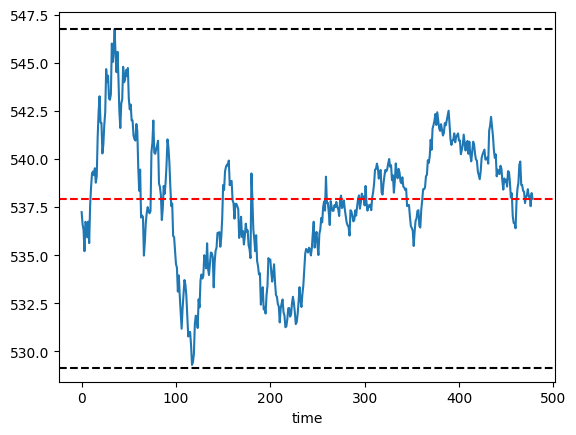

In [34]:
#df_all_days_stock['close'].plot(xlim=(300,400), ylim=(575,587))
df_all_days_stock['close'].plot()
plt.xlabel('time')
plt.axhline(y=y_value, color='r', linestyle='--', label=f'y = {y_value}')
plt.axhline(y=y_value_p, color='black', linestyle='--', label=f'y = {y_value_p}')
plt.axhline(y=y_value_m, color='black', linestyle='--', label=f'y = {y_value_m}')

In [35]:
## checking right options

In [36]:
def get_option_chain(symbol):
    contract = Stock(symbol=symbol, exchange='SMART', currency='USD')
    ib.qualifyContracts(contract)
    chains = ib.reqSecDefOptParams(underlyingSymbol=contract.symbol, futFopExchange="", underlyingSecType=contract.secType, underlyingConId=contract.conId)
    chain = [ c for c in chains if c.exchange =='SMART'][0]
    return chain

In [37]:
def get_options_chain_for_expiry(symbol, expiry, min_strike=0, max_strike=np.Inf):
    option_chain = get_option_chain(symbol)
    options=[]
    for strike in option_chain.strikes:
        if strike <= max_strike and strike >= min_strike:
            for right in ['C', 'P']:
                option = Option(symbol=symbol, lastTradeDateOrContractMonth=expiry, strike=strike, right=right, exchange='SMART', currency='USD')
                options.append(option)
    valid_options=ib.qualifyContracts(*options)
    return valid_options

In [38]:
### OPTION

In [39]:
def round_up_to_nearest_ten(num):
  """Rounds a number up to the nearest ten."""
  return math.ceil(num / 10) * 10


def find_closest_number(numbers, target):
  """
  Finds the number in a list that is closest to a target number.

  Args:
    numbers: A list of numbers.
    target: The target number.

  Returns:
    The number in the list that is closest to the target number.
  """
  if not numbers:
    return None
  
  closest_number = numbers[0]
  min_difference = abs(numbers[0] - target)

  for number in numbers:
    difference = abs(number - target)
    if difference < min_difference:
      min_difference = difference
      closest_number = number

  return closest_number


In [40]:
Rd_up_Entry = round_up_to_nearest_ten(Entry[0])
Rd_up_Entry

540

In [41]:
inferencing_date

datetime.date(2025, 4, 11)

In [42]:
#to_day = inferencing_date.strftime("20%y%m%d")
to_day="20250411"
print(to_day)

20250411


In [ ]:
print(Rd_up_Entry)

In [43]:
# getting valid option chains

valid_options = get_options_chain_for_expiry("META", to_day , min_strike= Rd_up_Entry  -30, max_strike=Rd_up_Entry +30,)

In [49]:
list_strke = []
for list_str in valid_options:
    list_strke.append(list_str.strike)
    
### OPTION to find closes available strike price

upper_strk_number = find_closest_number(list_strke, y_value_p)

#global Up_Call
Up_Call = upper_strk_number + 0

lower_strk_number = find_closest_number(list_strke, y_value_m)

#global Down_Put
Down_Put = lower_strk_number - 0

In [56]:
tickers_dict = {}
    
for option in valid_options:
    tickers_dict[(option.right, option.strike)] = ib.reqMktData(contract =option, genericTickList="", snapshot=False, regulatorySnapshot=False)
    #tickers_dict[(option.right, option.strike)] = ib.reqHistoricalData(contract =option)

ib.sleep(4)
    
ticker_call_to_sell_target = tickers_dict['C', Up_Call]
UCV = ticker_call_to_sell_target.midpoint()

ticker_put_to_sell_target = tickers_dict['P', Down_Put]
LPV = ticker_put_to_sell_target.midpoint()

print(f'current price({Entry})')
print(f'upper_strike ({Up_Call}) at {UCV}')
print(f'lower_strike ({Down_Put}) at {LPV}')

#############################
#SELL options
#############################


# Sample DataFrame
df = pd.DataFrame([{'time':datetime.now(),'upper_Call_value': UCV, 'lower_Put_value': LPV}])

df.to_pickle('price_move.pkl')

current price([537.94])
upper_strike (552.5) at 0.5700000000000001
lower_strike (525.0) at 0.12


In [52]:
Rd_up_Entry = round_up_to_nearest_ten(Entry)

# getting valid option chains

valid_options = get_options_chain_for_expiry("META", to_day , min_strike= Rd_up_Entry  -30, max_strike=Rd_up_Entry +30,)
#print(valid_options)

list_strke = []
for list_str in valid_options:
    list_strke.append(list_str.strike)
    
### OPTION to find closes available strike price

upper_strk_number = find_closest_number(list_strke, y_value_p)

#global Up_Call
Up_Call = upper_strk_number +5

lower_strk_number = find_closest_number(list_strke, y_value_m)

#global Down_Put
Down_Put = lower_strk_number - 5 


tickers_dict = {}
    
for option in valid_options:
    tickers_dict[(option.right, option.strike)] = ib.reqMktData(contract =option, genericTickList="", snapshot=False, regulatorySnapshot=False)

ticker_call_to_sell_target = tickers_dict['C', Up_Call]
UCV = ticker_call_to_sell_target.midpoint()

ticker_put_to_sell_target = tickers_dict['P', Down_Put]
LPV = ticker_put_to_sell_target.midpoint()

print(f'current price({Entry})')
print(f'upper_strike price({Up_Call})')
print(f'upper_strike price({Down_Put})')

#############################
#SELL options
#############################


# Sample DataFrame
df = pd.DataFrame([{'time':datetime.now(),'upper_Call_value': UCV, 'lower_Put_value': LPV}])

df.to_pickle('price_move.pkl')


C:\Users\jepar\AppData\Local\Temp\ipykernel_17816\2364919501.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.ceil(num / 10) * 10


current price([537.94])
upper_strike price(552.5)
upper_strike price(525.0)
